# Autoencoder Models Performance Analysis

## Notebook Overview 
The purpose of this notebook is to analyze the performance of various Autoencoder architectures through training and evaluation (T&E hereafter) on the CityLearn Challenge 2023 dataset.

### Imports
This section imports essential libraries used throughout the notebook and adds the 'src' directory to the system path to allow importing modules from the source folder. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.metrics import mean_squared_error
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderBasic as aeb
from dl_models import AutoencoderAdvanced as aea
from dl_models import AutoencoderRefined as aer
from utils import plots as plt

## Introductory test
As an initial approach to the model, this T&E will be performed on the samples from Building 1 of the dataset, targeting three features:
- Cooling demand
- Carbon intensity
- Solar generation

In this case, the baseline Autoencoder is adopted, a simple architecture composed of one encoder layer and one decoder layer, each with 64 neurons and linear activation functions.
One plot for each target is generated, highlighting the NMAE, NMSE, and NRMSE, to enable comparison with the normalized performance of other models considered in the project.

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

# Displaying the last 5 samples of the dataframe to show its structure.
df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [4]:
real_1, pred_1 = aeb.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size=256)

Epoch 1/1000
2/2 [==============================] - 1s 5ms/step - loss: 0.1333 - mean_absolute_error: 0.3241
Epoch 2/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.1209 - mean_absolute_error: 0.3085
Epoch 3/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.1097 - mean_absolute_error: 0.2929
Epoch 4/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0993 - mean_absolute_error: 0.2772
Epoch 5/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0894 - mean_absolute_error: 0.2611
Epoch 6/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0803 - mean_absolute_error: 0.2448
Epoch 7/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0719 - mean_absolute_error: 0.2288
Epoch 8/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0645 - mean_absolute_error: 0.2135
Epoch 9/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0581 - mean_absolute_error: 0.1989
Epoch 10/1000
2/2 

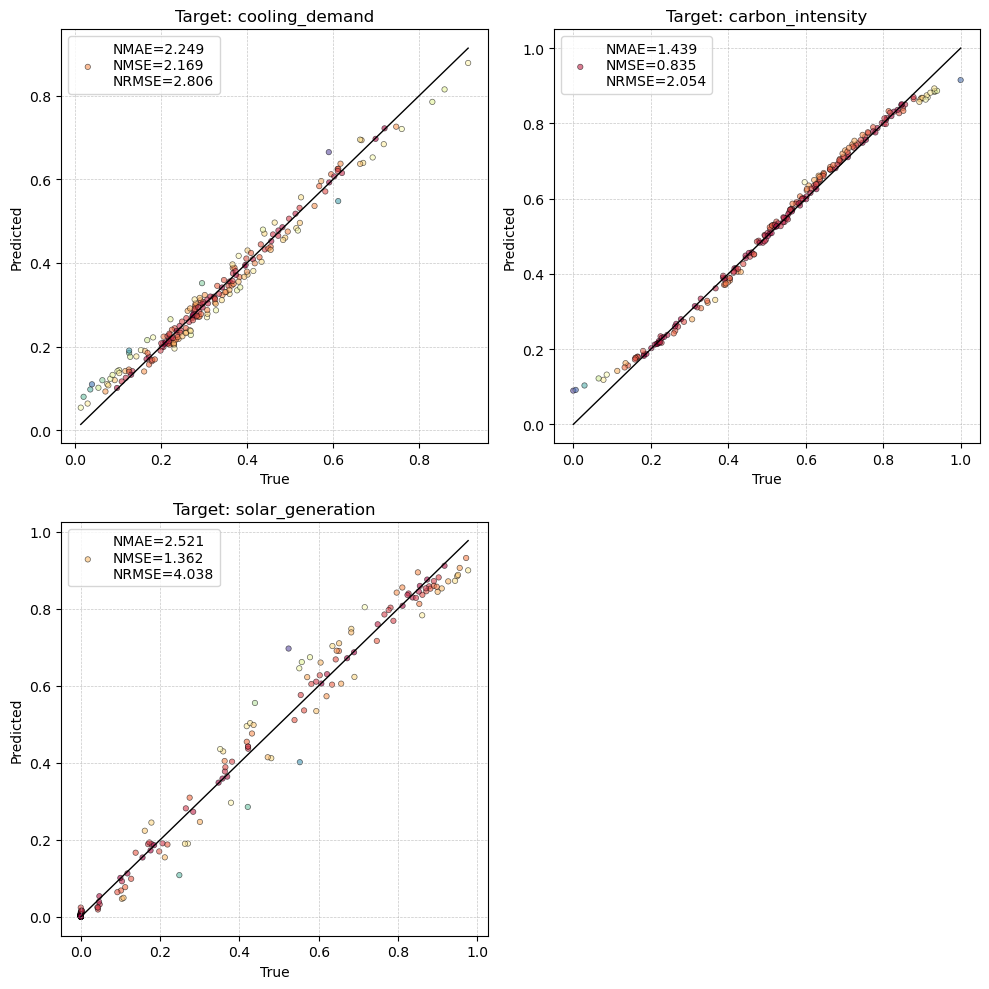

In [5]:
plt.plot_targets(real_1, pred_1, targets, features, percent=True)

## Cross-building test
The targets and the model remain unchanged. For this phase, we will use 100% of the data from Building 1 for training, while the remaining two buildings, being triplets with the first, will be used to evaluate the model's performance.

In [6]:
## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

In [7]:
train_df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [8]:
test_df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
1435,6,20,6,0,24.444447,0.000001,55.401950,0.981112,0.000000,3.581775,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
1436,6,21,6,0,24.444450,0.000005,55.363644,1.070561,0.000000,2.959194,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
1437,6,22,6,0,24.444450,0.000006,55.452953,0.816532,0.204833,2.480101,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
1438,6,23,6,0,24.444450,0.000006,55.501358,0.709542,1.768555,3.568882,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
1439,6,24,6,0,24.444440,-0.000004,55.706670,0.526549,0.000000,1.902680,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [9]:
real_2, pred_2 = aeb.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size=256)

Epoch 1/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1526 - mean_absolute_error: 0.3418
Epoch 2/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1326 - mean_absolute_error: 0.3201
Epoch 3/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1167 - mean_absolute_error: 0.3007
Epoch 4/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1030 - mean_absolute_error: 0.2816
Epoch 5/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0904 - mean_absolute_error: 0.2614
Epoch 6/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0785 - mean_absolute_error: 0.2401
Epoch 7/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0683 - mean_absolute_error: 0.2193
Epoch 8/3000
3/3 [==============================] - 0s 5ms/step - loss: 0.0602 - mean_absolute_error: 0.2006
Epoch 9/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0544 - mean_absolute_error: 0.1851
Epoch 10/3000
3/3 [

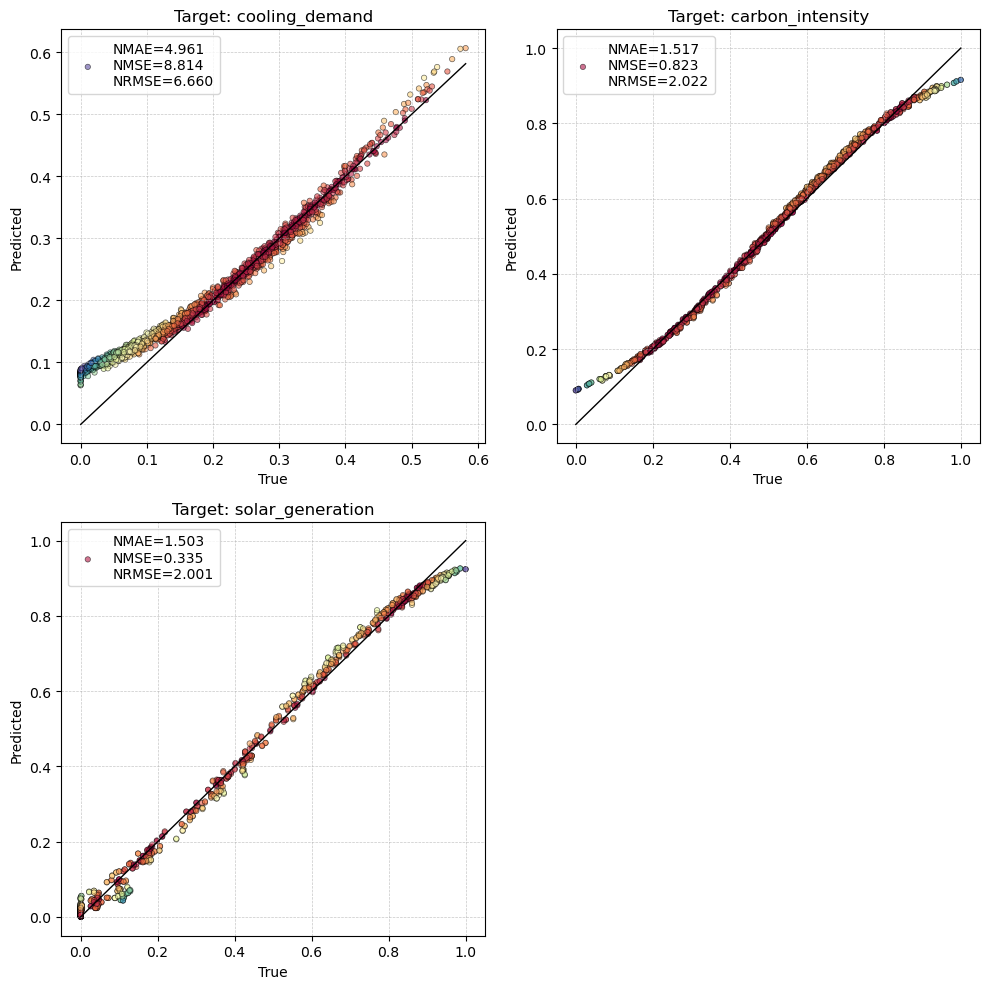

In [10]:
plt.plot_targets(real_2, pred_2, targets, features, percent=True)

## Enhanced Architectures test
In this section, we evaluate the previous tests on a more advanced autoencoder architecture, designed to improve the model's ability to learn from complex data and potentially reduce errors. This architecture introduces deeper layers, different activation functions, and other optimizations aimed at enhancing performance over the previous model.

### Adding Hidden Layers

Now, two hidden layers are added to both the encoder and decoder in order to enhance the model’s representation capacity.

Encoder:
- Dense layer with 128 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 32 units and linear activation.

Bottleneck (latent) layer with n units and linear activation.

Decoder:
- Dense layer with 32 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 128 units and linear activation.

Output layer with a sigmoid activation to reconstruct the input.

This structure is designed to capture more complex relationships within the data while maintaining symmetry between the encoding and decoding paths.

In [11]:
real_3, pred_3 = aea.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size = 64)

Epoch 1/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0828 - mean_absolute_error: 0.2316
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0377 - mean_absolute_error: 0.1233
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0249 - mean_absolute_error: 0.1018
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - mean_absolute_error: 0.0884
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_absolute_error: 0.0795
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0123 - mean_absolute_error: 0.0730
Epoch 7/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0105 - mean_absolute_error: 0.0672
Epoch 8/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0093 - mean_absolute_error: 0.0624
Epoch 9/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0085 - mean_absolute_error: 0.0594
Epoch 10/1000
8/8 [

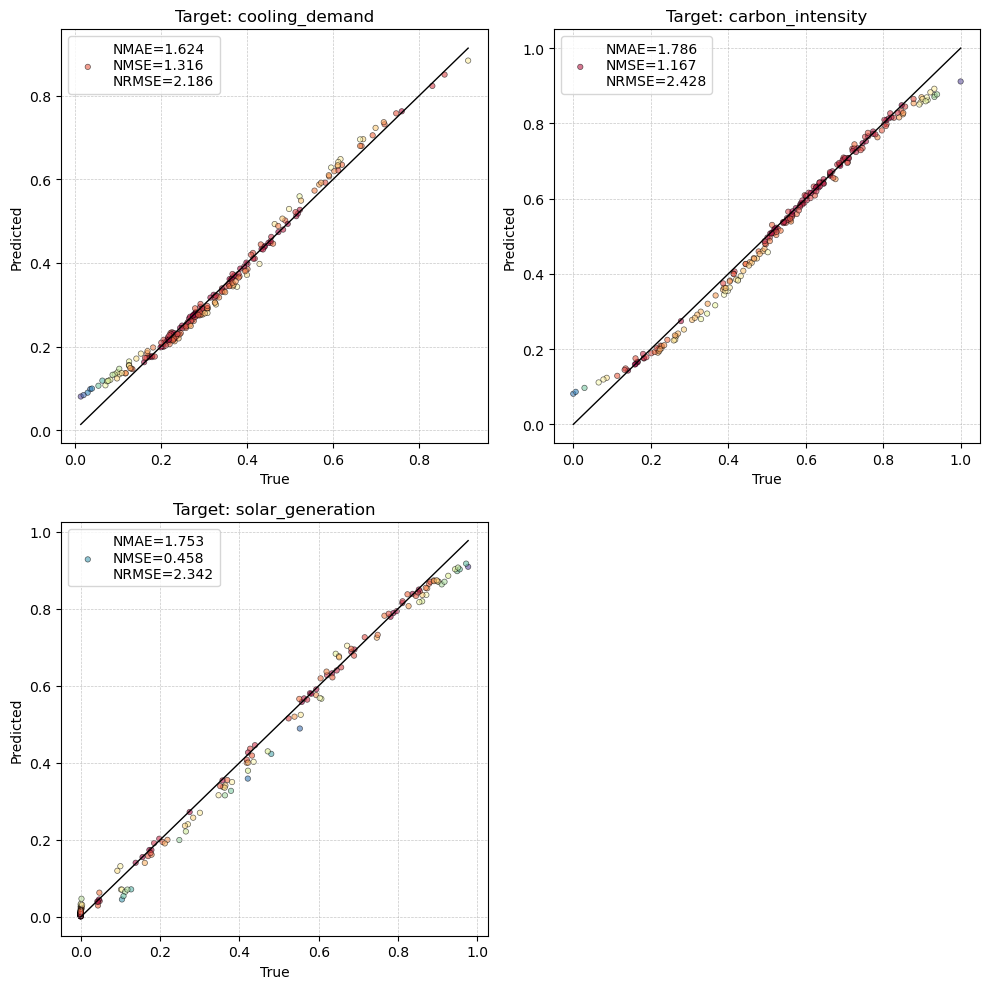

In [12]:
plt.plot_targets(real_3, pred_3, targets, features, percent=True)

In [13]:
real_4, pred_4 = aea.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size = 64)

Epoch 1/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0756 - mean_absolute_error: 0.2130
Epoch 2/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0283 - mean_absolute_error: 0.1096
Epoch 3/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0186 - mean_absolute_error: 0.0893
Epoch 4/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0134 - mean_absolute_error: 0.0772
Epoch 5/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0105 - mean_absolute_error: 0.0665
Epoch 6/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0087 - mean_absolute_error: 0.0602
Epoch 7/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0558
Epoch 8/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0529
Epoch 9/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0508
E

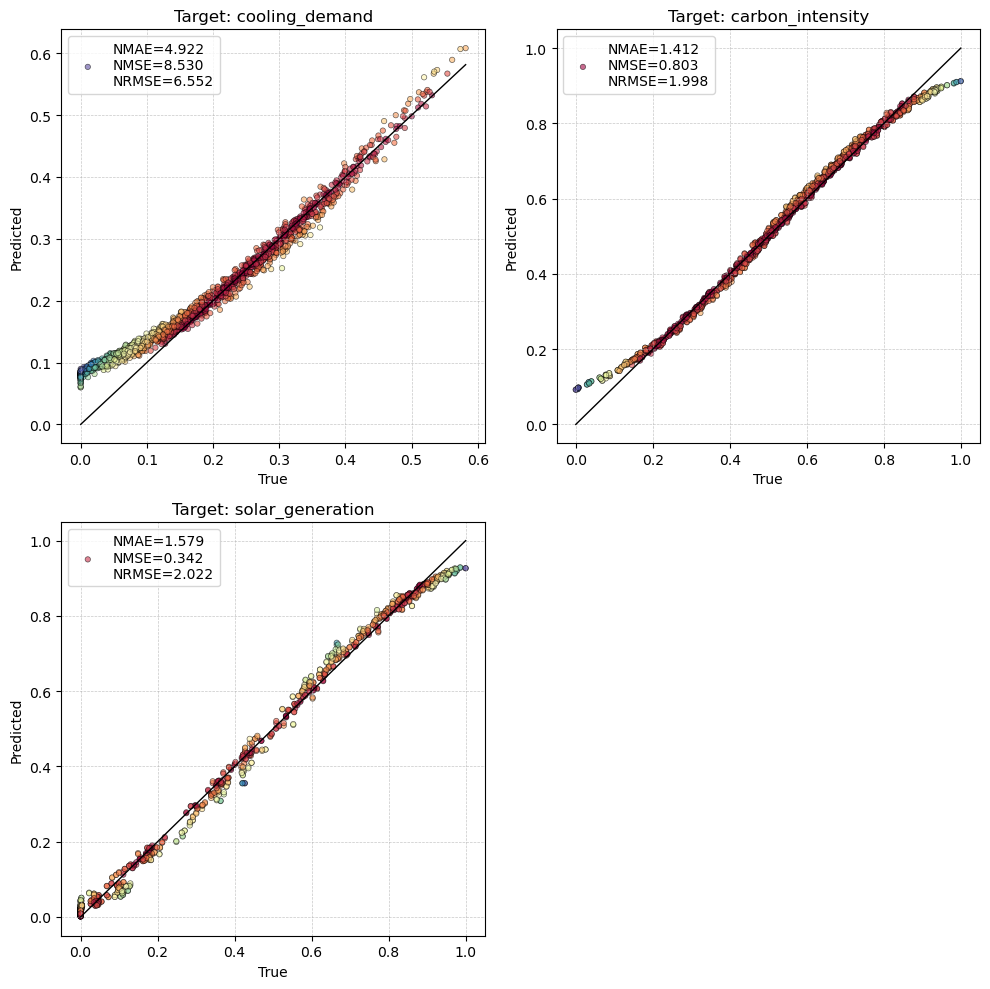

In [14]:
plt.plot_targets(real_4, pred_4, targets, features, percent=True)

### Introducing Non Linear Activation Functions and Model Enhancements

To further improve the reconstruction performance, this section introduces non-linear activation functions (e.g. ReLU, ELU) within the hidden layers of the autoencoder. Additionally, the model configuration is enhanced by experimenting with a different optimizer, adjusting the dimensionality of the latent space and adding the batch normalization procedure after every layer. These changes aim to boost the model’s representation power and optimize its ability to reconstruct complex patterns in the input features.

In [15]:
real_5, pred_5 = aer.Autoencoder(dataframe=df, features=features, epochs = 1000, latent_dim = 32, batch_size = 128)

Epoch 1/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1392 - mean_absolute_error: 0.3319
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1297 - mean_absolute_error: 0.3209
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1196 - mean_absolute_error: 0.3086
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1083 - mean_absolute_error: 0.2939
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0961 - mean_absolute_error: 0.2767
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0839 - mean_absolute_error: 0.2576
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0730 - mean_absolute_error: 0.2380
Epoch 8/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0643 - mean_absolute_error: 0.2195
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0580 - mean_absolute_error: 0.2035
Epoch 10/1000
4/4 [

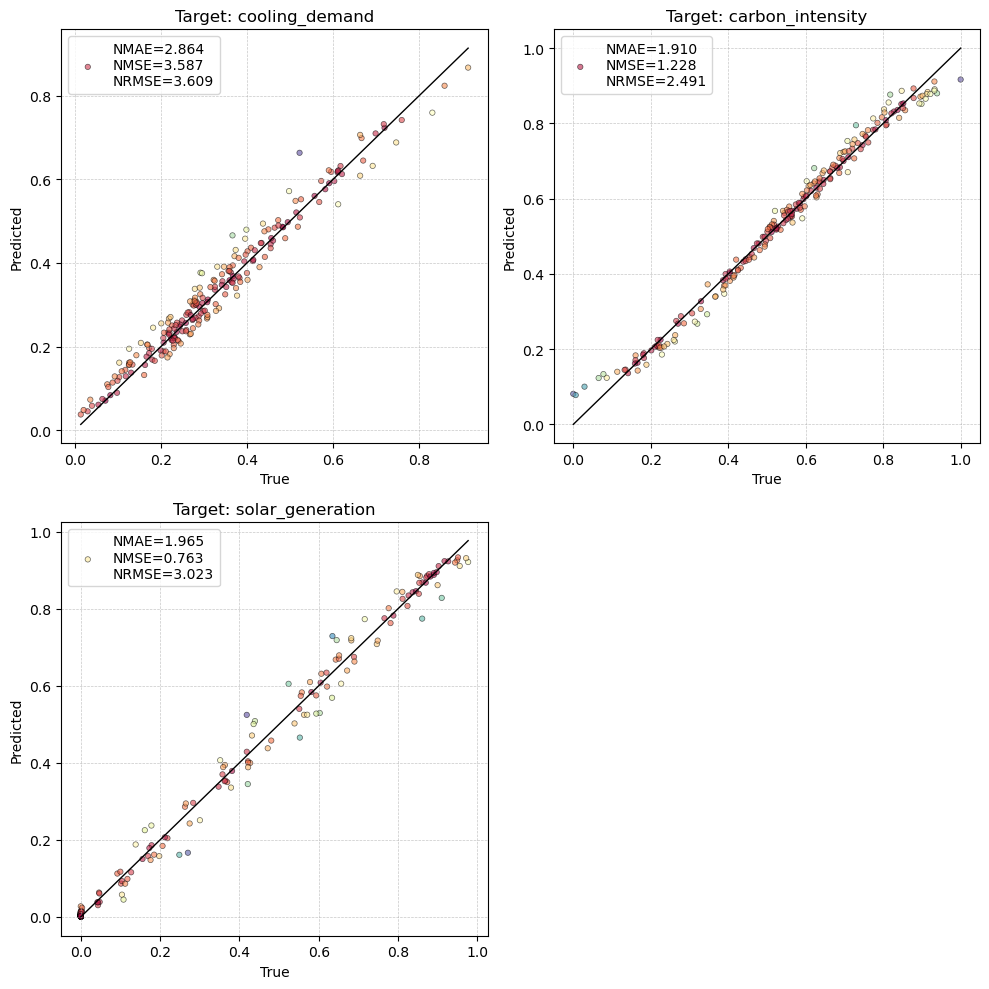

In [16]:
plt.plot_targets(real_5, pred_5, targets, features, percent=True)

In [17]:
real_6, pred_6 = aer.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, latent_dim = 32, batch_size = 128)

Epoch 1/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1339 - mean_absolute_error: 0.3256
Epoch 2/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1201 - mean_absolute_error: 0.3084
Epoch 3/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1047 - mean_absolute_error: 0.2877
Epoch 4/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0871 - mean_absolute_error: 0.2615
Epoch 5/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0705 - mean_absolute_error: 0.2325
Epoch 6/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0581 - mean_absolute_error: 0.2048
Epoch 7/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0501 - mean_absolute_error: 0.1817
Epoch 8/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0447 - mean_absolute_error: 0.1649
Epoch 9/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0404 - mean_absolute_error: 0.1527
Epoch 10/3000
6/6 [

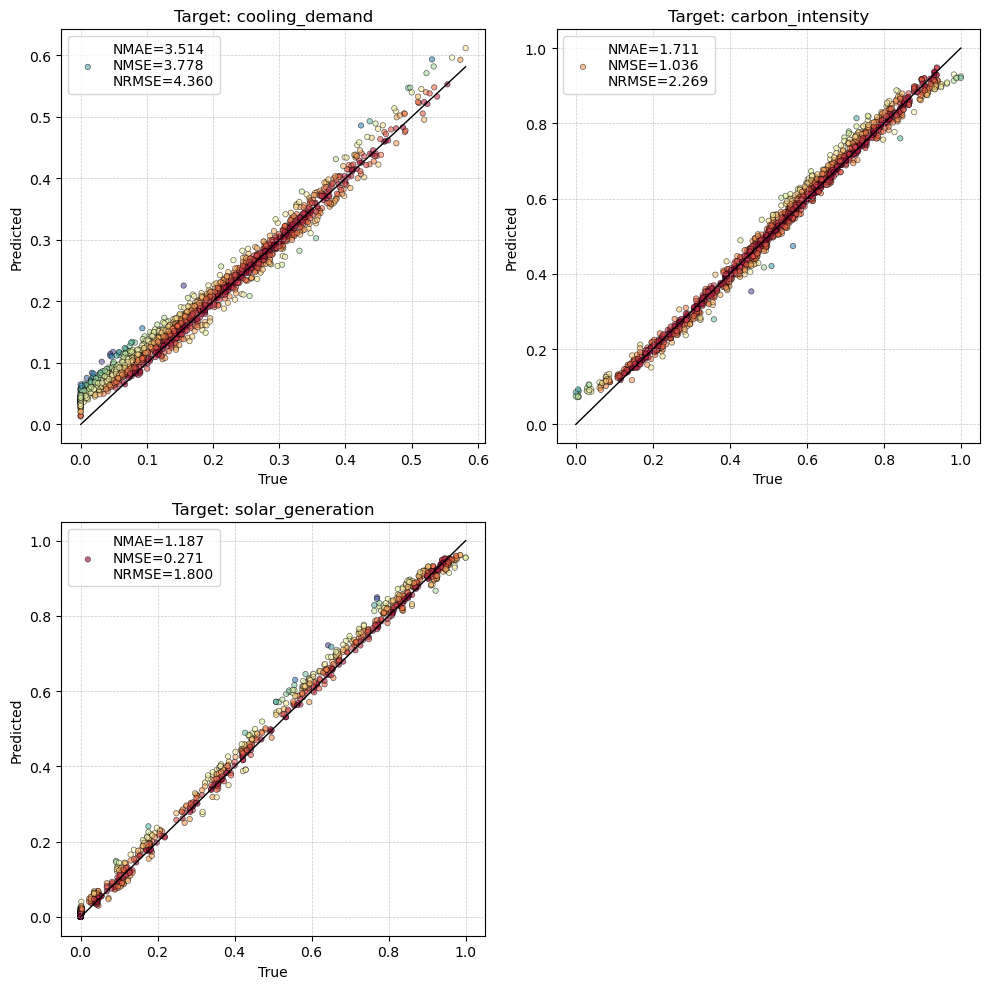

In [18]:
plt.plot_targets(real_6, pred_6, targets, features, percent=True)

## Observations
Cooling demand exp, carbon insensity arctan, non linear models -> best performance.